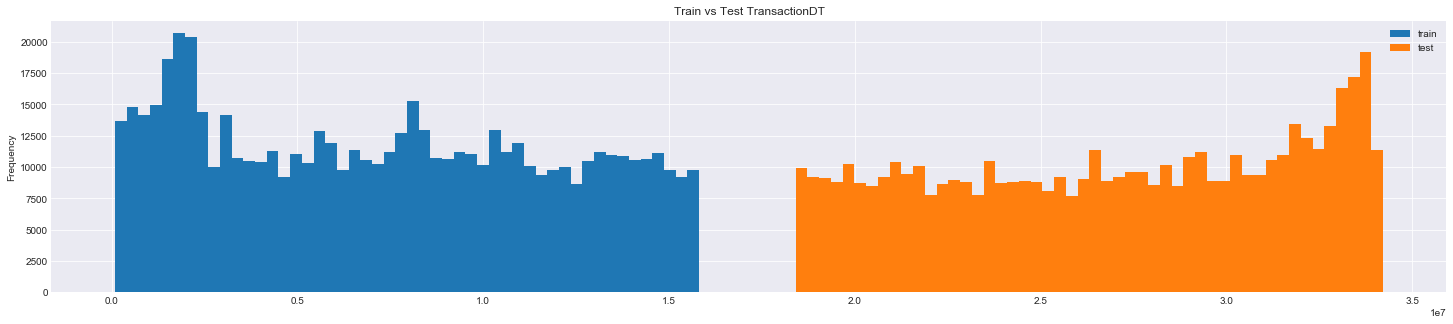

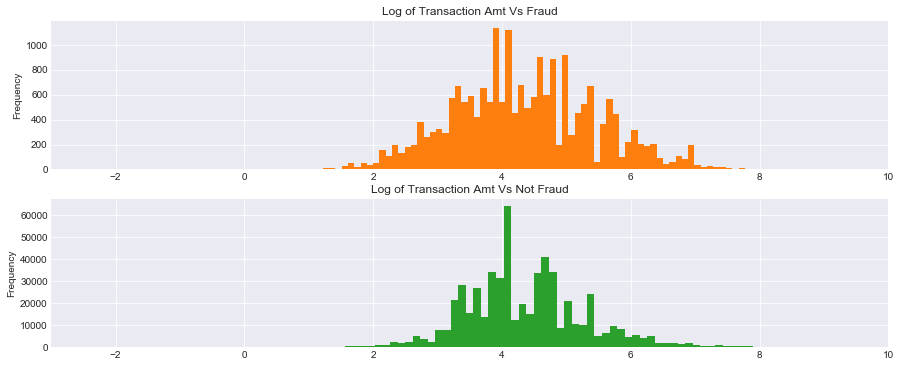

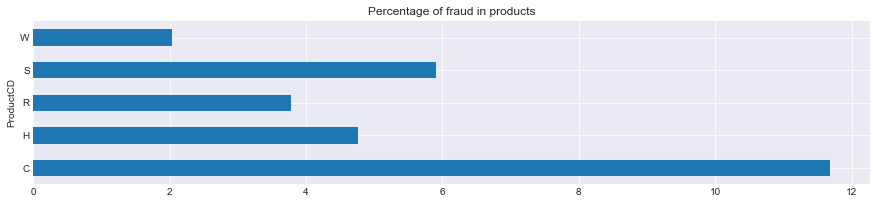

Accuracy is :0.7426955702167767


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
from sklearn import model_selection, preprocessing, ensemble, metrics, linear_model
import xgboost
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler


%matplotlib inline

output_path = f'{sys.path[0]}/sample_submission.csv'

warnings.simplefilter('ignore')
plt.style.use('seaborn-darkgrid')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

# Load dataset using Pandas

train_identity = pd.read_csv('ieee-fraud-detection/train_identity.csv')
train_transaction = pd.read_csv('ieee-fraud-detection/train_transaction.csv')
test_identity = pd.read_csv('ieee-fraud-detection/test_identity.csv')
test_transaction = pd.read_csv('ieee-fraud-detection/test_transaction.csv')

# Plot of Train vs Test TransactionDT using matplotlib and seaborn

train_transaction['TransactionDT'].plot(kind = 'hist', figsize = (25,5), label = 'train', bins = 50,
                                       title = 'Train vs Test TransactionDT')
test_transaction['TransactionDT'].plot(kind='hist', label = 'test', bins=50)
plt.legend()
plt.show()

#print(train_transaction.head())

# Plot of Transaction Amt Vs Fraud and Non Fraud transactions
      
fig,((graph1,graph2)) = plt.subplots(2,figsize=(15,6))
train_transaction.loc[train_transaction['isFraud']==1]\
['TransactionAmt'].apply(np.log).plot(kind='hist',
                                        bins=100,
                                        title='Log of Transaction Amt Vs Fraud',
                                        color=color_pal[1],
                                        xlim=(-3,10),
                                        ax=graph1)
train_transaction.loc[train_transaction['isFraud']==0]\
['TransactionAmt'].apply(np.log).plot(kind='hist',
                                        bins=100,
                                        title='Log of Transaction Amt Vs Not Fraud',
                                        color=color_pal[2],
                                        xlim=(-3,10),
                                        ax=graph2)

plt.show()


# Plot of percentage of fraud in Products

(train_transaction.groupby('ProductCD')['isFraud'].mean()*100).sort_index().plot(kind='barh',
                                                                           figsize=(15,3),
                                                                          title = 'Percentage of fraud in products')
plt.show()




# Merge train_transaction and train_identity using TransactionID
train_dataset = pd.merge(train_transaction, train_identity,
                      how='left', on='TransactionID')

# Merge test_transaction and test_identity using TransactionID
test_dataset = pd.merge(test_transaction, test_identity,
                       how='left', on='TransactionID')

# label encode the target variable - converting the labels into numeric form
def label_encode(dataset):

    encoder = preprocessing.LabelEncoder()

    non_num_cols = [dataset.columns[n] for n, i in enumerate(dataset.dtypes)
                    if i not in ('int64', 'float64')]

    for i in non_num_cols:
        dataset[i+'_mod'] = encoder\
            .fit_transform(dataset[i].fillna(dataset[i]
                                             .replace(np.nan, '0', regex=True).mode()[0]))

    col_list = [
        x for x in train_transaction.columns if x not in non_num_cols+['isFraud']]

    dataset = dataset[col_list].fillna(0)

    return dataset


# Create and fit the linear regression model. Predict the values of isFraud column in test dataset 
train_dt = label_encode(train_dataset)

train_dt = train_dt.fillna(0)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_dt)
train_dt = scaler.transform(train_dt)
rus = RandomUnderSampler(random_state=42)
x_train, y = rus.fit_resample(train_dt, train_dataset['isFraud'])

x_test = label_encode(test_dataset)
x_test = x_test.fillna(0)
scaler.fit(x_test)
x_test = scaler.transform(x_test)

LR = linear_model.LogisticRegression(n_jobs=-1)  
LR.fit(x_train, y)
predictions = LR.predict(x_test)

output = pd.DataFrame()
output['TransactionID'] = test_dataset['TransactionID']
output['isFraud'] = list(predictions)
output.to_csv(output_path, index=False)


# Calculate the accuracy of linear regression model
x_train, x_test, y_train, y_test = model_selection.train_test_split(train_dt
                                                                   , train_dataset['isFraud']
                                                                   , test_size = 0.25
                                                                   , random_state=42)



scaler.fit(x_train)
x_train = scaler.transform(x_train)
rus = RandomUnderSampler(random_state=42)
x_train, y_train = rus.fit_resample(x_train, y_train)
scaler.fit(x_test)
x_test = scaler.transform(x_test)
rus = RandomUnderSampler(random_state=42)
x_test, y_test = rus.fit_resample(x_test, y_test)

# Linear Regression model
LR = linear_model.LogisticRegression(n_jobs=-1, )
LR.fit(x_train, y_train)
predictions = LR.predict(x_test)

# Calculate accuracy
accuracy = metrics.accuracy_score(predictions, y_test)
print(f"Accuracy is :{accuracy}")
